# Generate Templates for DC2 data

Use DP0.2 data to generate templates to explore as part of DIA commissioning.

1. Get Dataset Repo
2. Identify region
   - Pick a tract, patch
3. Identify overlapping images.
    - Ask the coadd what images went into it?
    - Query for all of the overlapping images (we have the PVIs already)
4. Create a list of 3 images to add together to make a coadd
    - This might have to be outside the pipeline tasks

Learn about PipeTasks here
https://github.com/lsst/pipe_base/blob/main/doc/lsst.pipe.base/creating-a-pipelinetask.rst
https://github.com/lsst/pipe_base/blob/1a7e6827d4bd87e266f5e503fae571ff8ebbc83b/python/lsst/pipe/base/pipelineTask.py#L44

In [1]:
from lsst.daf.butler import Butler

In [2]:
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import numpy as np

afwDisplay.setDefaultBackend("matplotlib")

In [3]:
import lsst.pipe.base as pipeBase
from lsst.pipe.tasks.warpAndPsfMatch import WarpAndPsfMatchTask

still_w2022_22 = True
if still_w2022_22:
    from lsst.pipe.tasks.makeCoaddTempExp import MakeWarpTask
else:
    from lsst.pipe.tasks.makeWarp import MakeWarpTask
    
from lsst.pipe.tasks.assembleCoadd import AssembleCoaddTask
from lsst.pipe.tasks.coaddBase import makeSkyInfo

In [4]:
from lsst.pipe.base.testUtils import makeQuantum

In [6]:
config = "dp02"
collection = '2.2i/runs/DP0.2'

butler = Butler(config=config, collections=collection)

See Yusra AlSayyad's answer here for getting the input images for a coadd:
https://community.lsst.org/t/lightcurve-offset-on-difference-images/6912/14?u=mwv

Load a coadd

In [7]:
datasetType = 'deepCoadd'
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
coadd = butler.get(datasetType, dataId=dataId)

Here are the visit numbers for the images that were deemed to be goodSeeingVisits.

These are what were used to generate `goodSeeingCoadd` (This isn't required, this is just convention that we have to know.)

In [8]:
visits = butler.get("goodSeeingVisits", dataId=dataId)

In [9]:
visits.keys()

dict_keys([174602, 177422, 192350, 204595, 227884, 227891, 227918, 227922, 244023, 256348, 256393, 421693, 458494, 458531, 472072, 641116, 641121, 665694, 665695, 678507, 678546, 682771, 682810, 682811, 682821, 692583, 692613, 731753, 731790, 766972, 766973, 906936, 906984, 951274, 951283, 951317, 951318, 976126, 976165, 1173728, 1185854, 1196406, 1197816, 1197817, 1197853, 1205981, 1212011, 1217152, 1217205, 1231296, 1231906, 1231914, 1231943])

In [10]:
good_seeing_coadd = butler.get("goodSeeingCoadd", dataId=dataId)

The coadd knows its inputs

In [11]:
coadd_inputs = good_seeing_coadd.getInfo().getCoaddInputs()

Here are the input visits

In [12]:
print(coadd_inputs.visits)

   id   bbox_min_x bbox_min_y ... goodpix        weight         filter 
           pix        pix     ...                                      
------- ---------- ---------- ... -------- ------------------ ---------
 174602      11900       7900 ... 16007284 3.2125089233002555 i_sim_1.4
 177422      11900       7900 ... 16019807  4.434976230020358 i_sim_1.4
 192350      11900       7900 ... 10519975 1.8456782631444792 i_sim_1.4
 204595      11900       7900 ... 13241119 2.6841117656296216 i_sim_1.4
 227884      11900       7900 ... 16107207 1.7745749117959995 i_sim_1.4
 227891      11900       7900 ... 15884978 1.7725286547266133 i_sim_1.4
 227918      11900       7900 ... 16055749  1.768298327486471 i_sim_1.4
 227922      11900       7900 ...  1512880  1.745271720648272 i_sim_1.4
 244023      11900       7900 ... 16016993  1.828343826114231 i_sim_1.4
 256348      11900       7900 ... 15588080  4.221136152105246 i_sim_1.4
    ...        ...        ... ...      ...                ...   

And the input CCDs.  Multiple CCDs from a visit overlap a given tract+patch

In [13]:
print(coadd_inputs.ccds)

    id     bbox_min_x bbox_min_y ... goodpix        weight         filter 
              pix        pix     ...                                      
---------- ---------- ---------- ... -------- ------------------ ---------
 174602014          0          0 ...  6287584 3.2125089233002555 i_sim_1.4
 174602018          0          0 ...   330926 3.2125089233002555 i_sim_1.4
 174602021          0          0 ...  9388774 3.2125089233002555 i_sim_1.4
 177422138          0          0 ...  3026525  4.434976230020358 i_sim_1.4
 177422139          0          0 ...   289195  4.434976230020358 i_sim_1.4
 177422141          0          0 ... 10326121  4.434976230020358 i_sim_1.4
 177422142          0          0 ...  2377966  4.434976230020358 i_sim_1.4
 192350064          0          0 ...  7285825 1.8456782631444792 i_sim_1.4
 192350065          0          0 ...  3234150 1.8456782631444792 i_sim_1.4
 204595155          0          0 ... 12074091 2.6841117656296216 i_sim_1.4
       ...        ...    

Show the Image

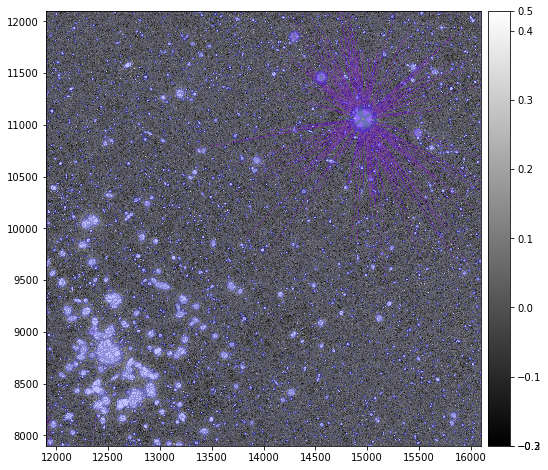

In [14]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale("linear", "zscale")
afw_display.mtv(coadd)

Show the Number of Images for each input pixel.  
This is saved in the "goodSeeingCoadd_nImage" dataset.

In [15]:
nImage = butler.get("goodSeeingCoadd_nImage", dataId=dataId)

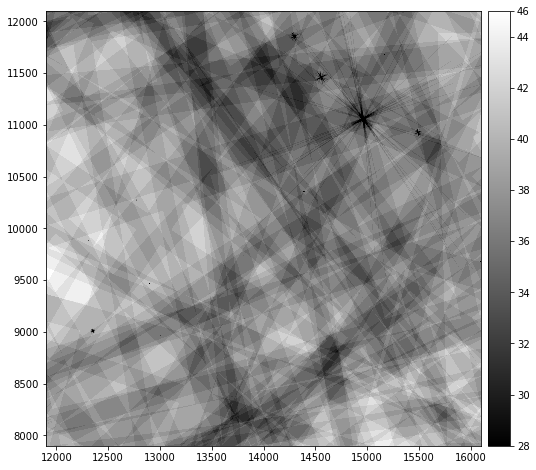

In [16]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale("linear", "zscale")
afw_display.mtv(nImage)

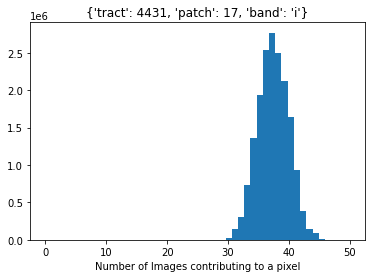

In [17]:
plt.hist(nImage.array.ravel(), bins=np.linspace(0, 50))
plt.xlabel("Number of Images contributing to a pixel")
plt.title(dataId);

Let's grab one of the images and look at it.

In [18]:
one_ccd = coadd_inputs.ccds[0]
print(one_ccd)

id: 174602014
bbox_min_x: 0
bbox_min_y: 0
bbox_max_x: 4071
bbox_max_y: 3999
ccd: 14
visit: 174602
goodpix: 6287584
weight: 3.21251
filter: i_sim_1.4



In [19]:
this_ccd_dataId = {"visit": one_ccd["visit"], "detector": one_ccd["ccd"], "physical_filter": one_ccd["filter"]}

In [20]:
this_ccd = butler.get("calexp", dataId=this_ccd_dataId)

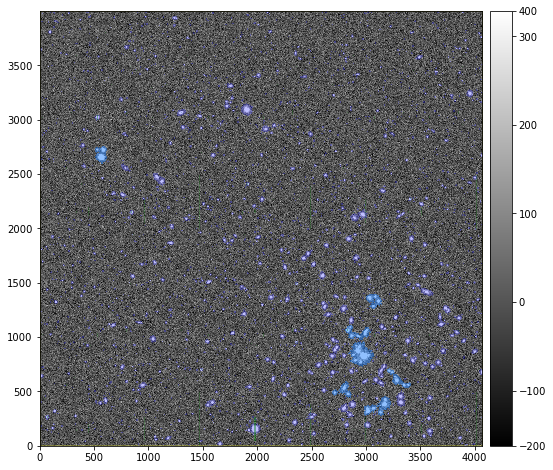

In [21]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale("linear", "zscale")
afw_display.mtv(this_ccd)

Notice that this is native pixel coordinates for the CCD.  We are seeing the entire CCD in the CCD frame.

Next lets look at the CCD in the coadd frame.

In [22]:
sky_map = butler.get("skyMap")
sky_info = makeSkyInfo(sky_map, tractId=dataId["tract"], patchId=dataId["patch"])

In [23]:
config = MakeWarpTask.ConfigClass()
makeWarp = MakeWarpTask(config=config)

/tmp/ipykernel_14440/1618863519.py:2: FutureWarning: Call to deprecated class CmdLineTask. (CmdLineTask is no longer supported. This functionality has been disabled. Use Gen3.) -- Deprecated since version v23.0.
  makeWarp = MakeWarpTask(config=config)


In [24]:
warp_ref_struct = makeWarp.run([this_ccd], [-1], sky_info)

In [27]:
warped_exposure = warp_ref_list.exposures["direct"]

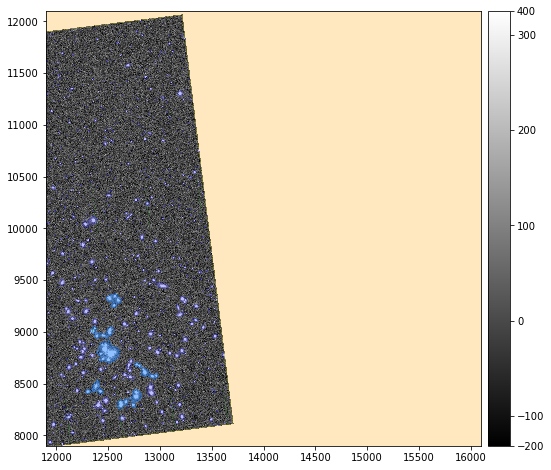

In [29]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale("linear", "zscale")
afw_display.mtv(warped_exposure)

This image will map into just the left ~third of the coadd.

Let's try the next CCD

In [32]:
one_ccd = coadd_inputs.ccds[1]
this_ccd_dataId = {"visit": one_ccd["visit"], "detector": one_ccd["ccd"], "physical_filter": one_ccd["filter"]}
this_ccd = butler.get("calexp", dataId=this_ccd_dataId)

In [35]:
warp2_ref_struct = makeWarp.run([this_ccd], [-1], sky_info)
warped_exposure = warp2_ref_struct.exposures["direct"]

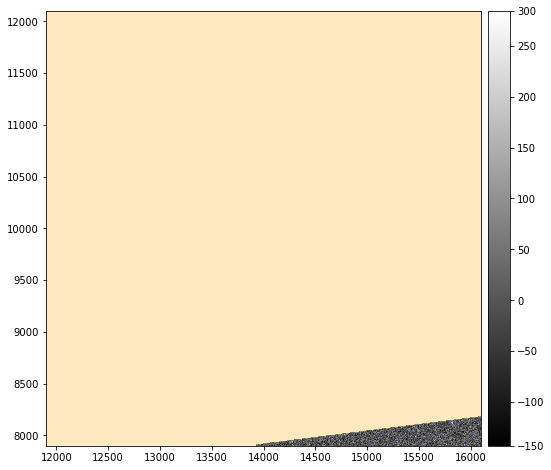

In [36]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale("linear", "zscale")
afw_display.mtv(warped_exposure)

And this second CCD just barely covers the lower-right corner.  You might even start to ask yourself, should we even include this CCD?

How do we add these two warps together?  AssembleCoadd.  But first we need to save them somewhere.  Coaddition in its general form often infolves much more data than fits in memoery.  So the coadd Tasks assume that they will get datasetRefs and not exposures.

This partial coverage in overlap and rotation leads to the complicated coverage pattern above in the nImage coverage.  This becomes a problem when creating coadds where we want a continuous PSF and even depth.

In [125]:
patch_ref = butler.registry.findDataset(datasetType="skyMap", dataId=dataId)

In [126]:
patch_ref

DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'DC2'}, id=ce366fef-1dad-4076-92a3-ec2775bbf593, run='skymaps')

In [129]:
input_data_ids = [{"visit": r["visit"], "detector": r["ccd"], "physical-filter": r["filter"]} for r in coadd_inputs.ccds[0:2]]
input_data_refs = [butler.registry.findDataset(datasetType="calexp", dataId=di) for di in input_data_ids]

In [130]:
input_data_refs

[DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 14, visit: 174602}, id=a04066cf-eeb3-4cd8-8aff-7fad22d8bc0d, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20211218T002844Z'),
 DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 18, visit: 174602}, id=423c4ba4-7ae7-450a-9a17-9eb5f3cb2900, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20211218T002844Z')]

In [135]:
help(makeSkyInfo)

Help on function makeSkyInfo in module lsst.pipe.tasks.coaddBase:

makeSkyInfo(skyMap, tractId, patchId)
    Return SkyInfo Struct
    
    Constructs SkyInfo used by coaddition tasks for multiple
    patchId formats.
    
    Parameters
    ----------
    skyMap : `lsst.skyMap.SkyMap`
    tractId : int
    patchId : str or int or tuple of int
        Either Gen2-style comma delimited string (e.g. '4,5'),
        tuple of integers (e.g (4, 5), Gen3-style integer.



In [131]:
makeWarp.runDataRef(patch_ref, input_data_refs)

AttributeError: 'DatasetRef' object has no attribute 'get'

In [37]:
config = AssembleCoaddTask.ConfigClass()
assembleCoadd = AssembleCoaddTask(name="makecoadd", config=config)

/tmp/ipykernel_14440/462911704.py:2: FutureWarning: Call to deprecated class CmdLineTask. (CmdLineTask is no longer supported. This functionality has been disabled. Use Gen3.) -- Deprecated since version v23.0.
  assembleCoadd = AssembleCoaddTask(name="makecoadd", config=config)


In [39]:
assemble_coadd_struct = assembleCoadd.run(sky_info,
                                          tempExpRefList=[warp_ref_list, warp2_ref_struct],
                                          imageScalerList=[1, 1], weightList=[1, 1])

AttributeError: 'Struct' object has no attribute 'get'

Try making a quantum-aware Butler.

In [ ]:
butlerQC = makeQuantum(Butler)

In [26]:
input_refs = [this_ccd_dataId]
output_refs = [this_ccd_dataId]

In [62]:
input_refs = pipeBase.Struct(calExpList=[this_ccd_dataId])

In [63]:
warp_ref_list = makeWarp.runQuantum(butler, input_refs, output_refs)

AttributeError: 'dict' object has no attribute 'datasetRef'

In [30]:
dataId

{'tract': 4431, 'patch': 17, 'band': 'i'}

In [42]:
foo = butler.get("skyMap", dataId=dataId)

In [39]:
from lsst.pipe.drivers.utils import getDataRef

In [47]:
patch_ref = getDataRef(butler, dataId=dataId, datasetType="coadd")

AttributeError: 'Butler' object has no attribute 'subset'

In [50]:
patch_ref = [ref for ref in butler.get("deepCoadd", dataId=dataId)]

TypeError: cannot unpack non-iterable int object

In [56]:
foo = butler.getDeferred("deepCoadd", dataId=dataId)

In [57]:
foo

DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7f7d3c0332b0>, ref=DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'DC2', tract: 4431, patch: 17}, id=d34c41da-f522-4ec1-a21a-12116578b0dc, run='2.2i/runs/DP0.2/v23_0_1/PREOPS-905/step3_22/20220304T174139Z'), parameters=None)

Can I even set up a Quantum connection aware butler from a Notebook?

In [59]:
warp_ref_list = makeWarp.runQuantum(butler, input_refs, output_refs)

AttributeError: 'list' object has no attribute 'calExpList'

In [ ]:
warp_ref_list

In [ ]:
warp_ref_list.exposures

In [ ]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale("linear", "zscale")
afw_display.mtv(coadd)

Let's create a coadd from this one image

Start here to see the ingredients
https://github.com/lsst/drp_pipe/blob/main/ingredients/LSSTCam-imSim/DRP.yaml

We want

makeWarp
assembleCoadd

which are defined in 

https://github.com/lsst/drp_pipe/blob/main/ingredients/DRP-minimal-calibration.yaml

```
makeWarp:
    class: lsst.pipe.tasks.makeWarp.MakeWarpTask
    config:
      makePsfMatched: true
assembleCoadd:
    class: lsst.pipe.tasks.assembleCoadd.CompareWarpAssembleCoaddTask
    config:
      doInputMap: true
```

In [ ]:
config = Coadd.ClassConfig()